In [1]:
# Import needed libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics

import nltk
import re
import html
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.classify import NaiveBayesClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB

from sklearn import metrics
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error, confusion_matrix, f1_score, classification_report, accuracy_score



In [3]:
# Read sentiment analysis datafile

df_sent = pd.read_csv("sentiment_analysis.csv", low_memory=False)
df_sent

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


In [4]:
# Read Canadian elections datafile

df_elec = pd.read_csv("Canadian_elections_2019.csv", low_memory=False)
df_elec

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."
...,...,...,...
2128,negative,Scandal,b'You know he was doing a good enough job smea...
2129,negative,Scandal,b'You missed the comment. Deflecting the issue...
2130,positive,NaN,b'Your daily reminder:\n@theJagmeetSingh endor...
2131,negative,Women Reproductive right and Racism,b'Yup...not going to reopen the abortion debat...


# 1. Data Cleaning

## 1.1 Remove HTML tags and attributes

To remove HTML tags and related attributes, the Regular Expression Operations library (re) is used because it is a module commonly used for natural language processing. First, a function is defined, in which an regular expression matching HTML and its related attributes are used to find the characters in the text and re.sub() is then used to replace the matching characters with "". The defined function is called html_tags_remover(), and is used on each row of the sentiment data and elections data using the apply() function, as shown below.

In [5]:
# Define a function to remove HTML tags using the re module

def html_tags_remover(text):
    cleaner = re.compile('<.*?>')
    return re.sub(cleaner,"",text)

In [6]:
# Remove HTML tags using the self-defined function

df_sent['text'] = df_sent['text'].apply(html_tags_remover)
df_elec['text'] = df_elec['text'].apply(html_tags_remover)

## 1.2 Convert HTML entities to ASCII equivalent 

To convert HTML entities (e.g. &amp;), the html module is used as it is designed specifically to handle HTML. First, a function is defined, in which html.unescape() is used to convert all HTML entities to their equivalent ASCII characters. The function is called html_to_ASCII, and is used on each row of the sentiment data and elections data using the apply() function, as shown below.

In [7]:
# Define a function to convert HTML entities to ASCII equivalent

def html_to_ASCII(text):
    return html.unescape(text)

In [8]:
# Convert all HTML entities to ASCII equivalent using the self-defined function

df_sent['text'] = df_sent['text'].apply(html_to_ASCII)
df_elec['text'] = df_elec['text'].apply(html_to_ASCII)

## 1.3 Remove URLs, handles, bytes characters, new line characters, and "RT"

To remove URLs, a function called URLs_remover is defined, in which an expression matching URL links is used to fined URLs in the text and re.sub() is used to replace the URLs found with "".

In [9]:
# Define a function to remove URLs

def URLs_remover(text):
    cleaner = re.compile(r'https?:\/\/\S*', re.IGNORECASE)
    return re.sub(cleaner,"",text)

It is deemed that the tag handles and tagged users provide little insights and therefore should be removed. A function called handles_remover is defind, in which an expression matching the tag handle and the following characters is used to find the tagged users in the text and res.sub() is used to replace the tag handle with "".

In [10]:
# Define a function to remove handles

def handles_remover(text):
    cleaner = re.compile(
    r'@[^\s]+'
    ,re.IGNORECASE)
    return re.sub(cleaner,"",text)

It is found that the text contains a large amount of new line characters and re-tweet (RT) characters. These characters will become noise during sentiment analysis and therefore should be removed. A function called nl_remover is defined, in which replace() is used to replace the literal new line strings and re-tweet strings with "".

In [11]:
# Define a function to remove the new line characters (the literal \n) in each text

def nl_remover(text):
    return text.replace("\\n"," ").replace("RT","")

After all necessary function are defined, they are used on each row of sentiment and election dataset using the apply() function, as shown below.

In [12]:
# Remove all URLs using the self-defined function

df_sent['text'] = df_sent['text'].apply(URLs_remover)
df_elec['text'] = df_elec['text'].apply(URLs_remover)

In [13]:
# Remove all handles using the self-defined function

df_sent['text'] = df_sent['text'].apply(handles_remover)
df_elec['text'] = df_elec['text'].apply(handles_remover)

In [14]:
# Remove the new line characters

df_sent['text'] = df_sent['text'].apply(nl_remover)
df_elec['text'] = df_elec['text'].apply(nl_remover)

It is also found that the text contains a large amount of literal bytes strings (e.g. b''). These strings will become noise during sentiment analysis and should be removed. To remove them, str.strip() is used to strip both the leading and trailing b'' characters in the text.

In [15]:
# Remove the bytes characters from the string text using strip

df_sent['text'] = df_sent['text'].str.strip("b\'\"")
df_elec['text'] = df_elec['text'].str.strip("b\'\"")

## 1.4 Convert all text to lower case

To transform all text into lower case, a lambda function using lower() is applied on each row of the sentiment and election data through the apply() function, as shown below.

In [16]:
# Convert all text to lower case

df_sent['text'] = df_sent['text'].apply(lambda x: x.lower())
df_elec['text'] = df_elec['text'].apply(lambda x: x.lower())

## 1.5 Store hashtags separately

It is deemed that hashtags provide useful insights in sentiment analysis. Therefore, all hashtags in each text are extracted and stored in a separate column for potential use in downstream analysis. A function called extract_hashtags() is defined, in which re.findall() is used to match all hashtags in the text and return them as output. If no hashtags are found, the function returns NA.

In [17]:
# Define a function to extract hashtags

def extract_hashtags(text):
    return str(re.findall(r'\B#\w*[a-zA-Z]+\w*', text))[1:-1] if (re.findall(r'\B#\w*[a-zA-Z]+\w*', text)) else "NA"



The function is used on each row of the sentiment and election dataset using the apply() function, as shown below.

In [18]:
# Store extracted hashtags in a separate column and remove them from the text columm

df_sent['hashtags'] = df_sent['text'].apply(extract_hashtags)
df_elec['hashtags'] = df_elec['text'].apply(extract_hashtags)

Once extracted, a lambda function used to remove the pound sign and other punctuations from the hashtag strings is used on each row of sentiment and election data by the apply() function.

In [19]:
# Remove '', pound sign and other punctuations from hashtags

df_sent['hashtags'] = df_sent['hashtags'].apply(lambda x: x.replace("\'","").replace("#","").replace(",",""))
df_elec['hashtags'] = df_elec['hashtags'].apply(lambda x: x.replace("\'","").replace("#","").replace(",",""))

## 1.6 Remove punctuations

A lambda function consisting of replace() is applied on each row of the sentiment and election data to remove punctuations including any remaining pound signs, commas, periods, hyphens, colons, semi-colons, exclaimation marks, question marks, parentheses, etc.

In [21]:
# Remove all punctuations

df_sent['text'] = df_sent['text'].apply(lambda x: x.replace("#","").replace(",","").replace("."," ").replace("-","").replace(":","").replace(";","").replace("!","").replace("?","").replace("/","").replace("(","").replace(")","").replace("|",""))
df_elec['text'] = df_elec['text'].apply(lambda x: x.replace("#","").replace(",","").replace("."," ").replace("-","").replace(":","").replace(";","").replace("!","").replace("?","").replace("/","").replace("(","").replace(")","").replace("|",""))


## 1.7 Remove stopwords

As the text data contains phrases in their contracted form, a function is defined to change the contracted phrases into their non-contracted form (e.g. we're => we are). The function uses regular expressions to match contracted phrases and re.sub() is used to replace the matched phrases with the non-contracted form. The function is applied to each row of the sentiment and election dataset through the apply() function.

In [22]:
# Define a function to convert contracted word to its non-contracted form (e.g. don't => do not)

def decontracted(text):
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text) # this will change possession (e.g. someone's to someone is)?
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [23]:
# Convert contracted word to its non-contracted form

df_sent['text'] = df_sent['text'].apply(decontracted)
df_elec['text'] = df_elec['text'].apply(decontracted)

To remove stopwords, the NLTK library is used as it is a commonly used tool kit for natural language processing. From the NLTK library, existing stopwards library is downloaded and the English stopwards are printed below.

In [24]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lilysun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

It is noticed that the English stopwords contain words such as "not" and "no", which are very critical for determining sentiment and should not be removed from the text. Therefore, "not" and "no" are excluded from the stopwords library through a subtraction between the two lists, as shown below.

In [26]:
# Remove not and no from the stopword list as not and no may be important to 

sw = set(stopwords.words('english')) - {'not', 'no'}
print(sw)

{'while', "needn't", 'theirs', 'he', 'herself', 'an', 'in', 'too', 'doing', 'will', 'but', 'few', "mustn't", 'by', "she's", 'from', 'any', 'each', 'her', 'it', 'has', 'because', 'for', 'our', 'itself', 'before', 'didn', "you'll", "should've", 's', 'if', 'above', 'o', 'ain', 'when', 'been', 'does', "it's", 'again', 'should', 'hadn', "wouldn't", "mightn't", 'only', 'some', 'with', 'mustn', 'between', 'him', 'here', "shan't", 'this', 'into', 'hers', 'same', 'needn', 'other', 'at', 'than', 'of', 're', "you've", 'own', 'off', 'then', 've', 'd', "haven't", "wasn't", 'my', "weren't", "aren't", "couldn't", "hasn't", 'shouldn', 'on', 'and', 'y', 'have', 'myself', 'isn', 'can', 't', 'them', 'shan', "you're", "won't", 'its', 'was', 'won', "isn't", 'nor', 'what', 'wouldn', 'she', 'yourselves', 'are', 'is', 'how', 'don', 'whom', 'll', 'mightn', 'me', 'yours', 'after', 'until', 'just', 'over', "don't", 'had', 'up', 'why', 'being', 'ours', 'these', "that'll", "you'd", 'or', 'aren', 'were', 'about', '

In [27]:
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/lilysun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

A function called swlm_remover() is defined to remove all stopwords. Before removing stopwords, lemmatization is performed to transform all verbs to their base forms. Then, stopwords are filtered out and the remaining words are joined back together. The function is applied to each row of the sentiment and election dataset by the apply() function, as shown below.

In [28]:
# Define a function to remove stopwords and perform lemmatization in the above list

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer('\s+', gaps=True)

def swlm_remover(text):  
    words=tokenizer.tokenize(text)
    lemmatized = [lemmatizer.lemmatize(w, pos='v') for w in words if w not in sw]
    filtered = ' '.join(lemmatized)
    return filtered


In [29]:
# Remove stopwords

df_sent['text'] = df_sent['text'].apply(swlm_remover)
df_elec['text'] = df_elec['text'].apply(swlm_remover)

## 1.8 Remove hex digits

It is found that the text contains a large amount of hex digits (e.g. \x70) and these hex digits should be removed as theh will become noise during downstream analysis. A function called remove_rex() is defined where a regular expression is used to match all hex digits and re.sub() is used to replace these digits with a space. As there may be multiple hex digits within one text, multiple spaces will result. Multiple spaces within one text are then replaced with a single space. The function is applied to each row of the sentiment and election dataset by the apply() function, as shown below.

In [30]:
# Define a function to remove all hex digits

def remove_hex(text):
    text = re.sub(r'\\x(?:[0123456789abcdef]{2,2}|[0123456789abcdef]{4,4})', ' ', text)
    text = re.sub(' +', ' ', text)
    return text

In [31]:
# Remove hex digits

df_sent['text'] = df_sent['text'].apply(remove_hex)
df_elec['text'] = df_elec['text'].apply(remove_hex)

# 2. Exploratory analysis

## 2.1 Determine political party

Hashtags are deemed important for determining the political party as they themselves are often keywords related to a certain topic. Therefore, it is decided to get an overview of the hashtags in the election dataset by checking the 100 most common hashtags. First, all hashtags are tokenized and stored in a single list using the two defined functions below. Then, using the FreqDist() from the NLTK library, the frequency distribution of each occurence of hashtag is calculated. Then, using the most_common() attributes, the 100 most common hashtags can be accessed and are printed below. These hashtags provide some degrees of insights related to the political parties and will be used to construct lists of searchwords to be used for determining political affiliations.

In [32]:
# Get an overview of the most popular hashtags by checking the frequency
# Define a function to store all hashtags in a list

from nltk import FreqDist

tag_list = []

def store_tokens(text):
    tokens_list = word_tokenize(text)
    for tokens in tokens_list:
        tag_list.append(tokens)
    return tag_list

# Define a function to return tokenized hashtags
def get_all_words(tokens_list):
    for tokens in tokens_list:
        for token in tokens:
            yield token

In [33]:
# Store all hashtag tokens in a list
all_tags = get_all_words(df_elec['hashtags'].apply(store_tokens))

# Check the 100 most common hashtags 
freq_dist = FreqDist(all_tags)
print(freq_dist.most_common(100))

[('elxn43', 4494231), ('cdnpoli', 2459349), ('chooseforward', 347679), ('cpc', 172773), ('trudeaumustgo', 159975), ('cdnelxn2019', 147177), ('elxn2019', 145044), ('kinsellagate', 130113), ('canada', 125847), ('uprisingh', 106650), ('ndp', 98118), ('abpoli', 89586), ('onpoli', 87453), ('scheerlies', 85320), ('ppc2019', 81054), ('polcan', 81054), ('cdnmedia', 76788), ('canadavotes2019', 74655), ('bcpoli', 74655), ('itsourvote', 70389), ('ableg', 68256), ('cndpoli', 63990), ('canadavotes', 61857), ('lpc', 55458), ('skpoli', 55458), ('ppc', 53325), ('scheerdisaster', 53325), ('scheer', 53325), ('canpoli', 49059), ('andrewscheer', 46926), ('vote', 44793), ('election2019', 42660), ('kinsella', 42660), ('chooseforwardwithtrudeau', 42660), ('getoutthevote', 40527), ('trudeau', 38394), ('scheerhypocrisy', 36261), ('nbpoli', 34128), ('scheer4pm', 31995), ('teamtrudeau', 31995), ('nspoli', 31995), ('nlpoli', 31995), ('representationmatters', 31995), ('trudeaublackface', 29862), ('initforyou', 298

Based on the hashtags above, 5 political parties are identified, namely Liberal Party of Canada, Conservative Party of Canada, New Democratic Party, People's Party of Canada and Green Party of Canada. Independent research is then conducted on twitter and additional relevant hashtags are gathered for each political party, as shown below. Using these hashtags, 5 lists of search words are constructed, which will be used to determine political affiliations.

In [34]:
# Define search words related to a certain political party / candidate based on results above and independent research on internet

liberal_words = ['lpc','liberal','liberals','trudeaumuststay','chooseforward',
                 'chooseforwardwithtrudeau','teamtrudeau','voteliberal', 'votingliberal',
                 'representationmatters','proportionalrepresentation','istandwithtrudeau',
                 'teamliberal','standwithtrudeau']

conservative_words = ['cpc','trudeaumustgo','andrewscheer','andrew scheer','scheer',
                      'scheerisright','votecpc','votingcpc','trudeauworstpm','liberalmustgo',
                      'savecanada','firealllibs','scheermajority']

ndp_words = ['ndp','uprisingh','jagmeetsingh','votendp','votingndp','initforyou',
             'singhsurge','imwithjagmeet','singhupswing','upswingh',
            'ndpmajority']

ppc_words = ['ppc','maximebernier','choosemaxime','voteppc','votingppc','peoplespartyofcanada','ppc2019']

gpc_words = ['greenparty','gpc','votegpc','votinggpc','greensurge','votegreen']

A function called pp_identifier() is defined to output political affiliation for each text using the searchwords defined above. Basically, if any word in the text matches with one of these searchwords, then the matching word's corresponding political party will be the political affiliation of that text.

In [35]:
# Define a function to identify politcal party

def pp_identifier(text):
       
    tokens_list = word_tokenize(text)
    
    if any(word in liberal_words for word in tokens_list):
        return 'liberal'
    
    elif any(word in conservative_words for word in tokens_list):
        return 'conservatives'
    
    elif any(word in ndp_words for word in tokens_list):
        return 'ndp'
    
    elif any(word in ppc_words for word in tokens_list):
        return 'ppc'
    
    elif any(word in gpc_words for word in tokens_list):
        return 'gpc'
    
    else:
        return 'other/unknown'
    

pp_identifier() is applied to the election dataset and the output is stored in a list and then added as a new column to the election dataset for visualization.

In [36]:
# Run pp_identifier to define politial affiliations for each sample

politcal_party = []

for i in range (0,len(df_elec)):
    politcal_party.append(pp_identifier(df_elec.iloc[i]['text']))
    
df_elec['Party'] = politcal_party

In [37]:
# Check frequencies of each political party

df_elec['Party'].value_counts()

other/unknown    1227
liberal           381
conservatives     342
ndp               105
ppc                68
gpc                10
Name: Party, dtype: int64

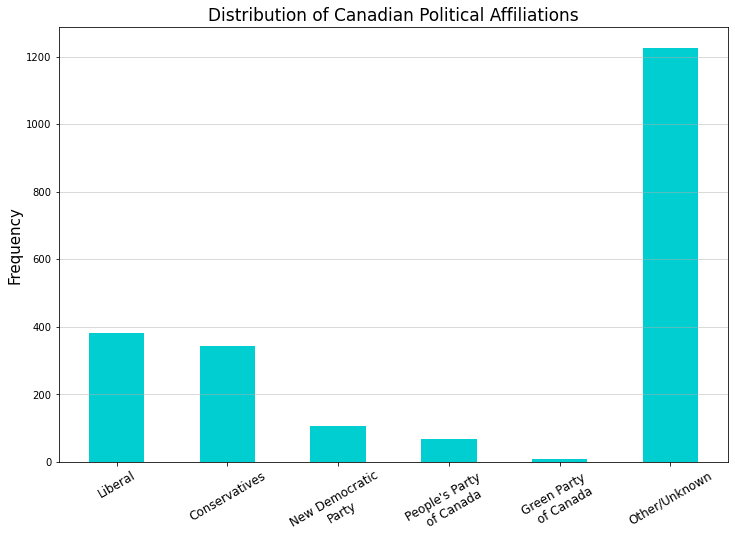

In [38]:
# Plot the distribution of each political affiliation

party_cat = ["Liberal","Conservatives","New Democratic\nParty","People's Party \n of Canada", "Green Party \n of Canada",
            "Other/Unknown"]

Freq = [381,342,106,68,10,1226]

X = np.arange(len(party_cat))

fig,ax = plt.subplots(1,figsize=(12,8))
fig = ax.bar(X, Freq, color = 'darkturquoise', width = 0.5)
ax.set_xticks(X)
ax.set_xticklabels(party_cat, rotation = 30, fontsize = 12)
ax.set_ylabel("Frequency", fontsize=15)
ax.grid(axis='y', alpha=0.6)
plt.title("Distribution of Canadian Political Affiliations", fontsize=17)

plt.show()

As shown above, the majority of the tweets have "Other/Unknown" as their political affiliation, possibly because the searchwords lists are not complete and do not contain all the relevant hashtags used in the tweets. Another reason may be that some tweets do not contain any hashtags. 

Looking at the tweets that have an identified political affiliation, it is observed that Liberal Party of Canada has the highest frequency, followed by Conservative Party of Canada, New Democratic Party, People's Party of Canada and Green Party of Canada. This result makes sense in that Liberal Party of Canada and Conservative Party of Canada are two major big political parties with high popularity. However, Liberal Party did not retain its popularity in the 2019 election and lost its popular vote to Conservative Party. Therefore, it is possible that the procedure for determining the political affiliation are not accurate and more sophisticated methods will be needed. However, many other factors also need to be considered, such as but are not limited to: 1) Many tweets do not specifically express specific support for a certain political party but only opposition towards some parties. 2) The demographic information of the twitter users will affect the frequency of each political affiliation. For example, supporters for Liberal Party mostly reside in urban areas and have more younger generation. These users will have a higher likelihood of using twitter and have a better understanding of technology (e.g. how to use hashtags and how to use the right hashtags).

## 2.2 Exploratory analysis

For the exploratory analysis, wordclouds are generated for the positive and negative tweets in the election data. 

In [39]:
!pip install wordcloud

In [40]:
from wordcloud import WordCloud

In [41]:
# Remove any remaining punctuations
df_sent['text']=df_sent['text'].apply(lambda text: re.sub(r'[^\w\s]','',text))
df_elec['text']=df_elec['text'].apply(lambda text: re.sub(r'[^\w\s]','',text))

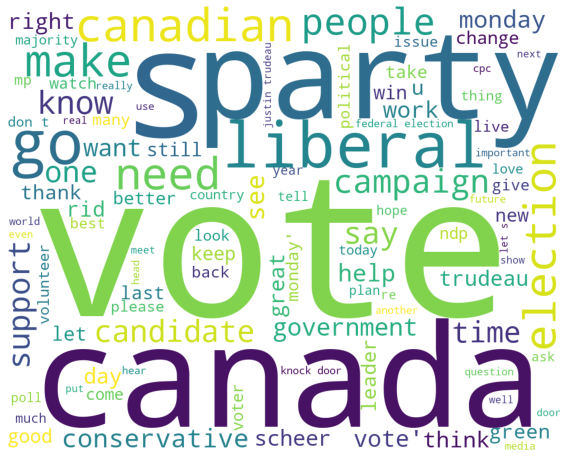

In [42]:
# Look at keywords in tweets with positive sentiment in election dataset

df_elec_pos = df_elec.loc[df_elec['sentiment']=='positive'] # Select rows with positive sentiment only

# Store all word tokens in a list

content_list = []

for i in range (0, len(df_elec_pos)):
    tokens_text = word_tokenize(df_elec_pos.iloc[i]['text'])
    tokens_hash = word_tokenize(df_elec_pos.iloc[i]['hashtags'])
    content_list.append(' '.join([token for token in tokens_text if token not in tokens_hash]))

content_list = str(content_list)
content_list = ''.join(content_list)

wordcloud = WordCloud(width = 1000, height = 800, background_color='white', max_words=100, random_state=10).generate(content_list)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

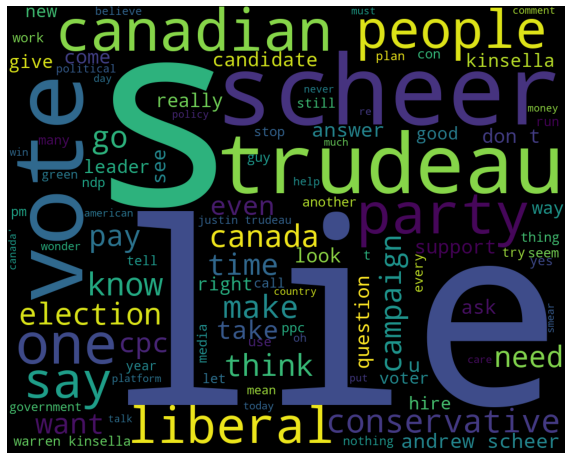

In [43]:
# Look at keywords in tweets with negative sentiment in election dataset

df_elec_neg = df_elec.loc[df_elec['sentiment']=='negative'] # Select rows with positive sentiment only

# Store all word tokens in a list

content_list = []

for i in range (0, len(df_elec_neg)):
    tokens_text = word_tokenize(df_elec_neg.iloc[i]['text'])
    tokens_hash = word_tokenize(df_elec_neg.iloc[i]['hashtags'])
    content_list.append(' '.join([token for token in tokens_text if token not in tokens_hash]))

content_list = str(content_list)
content_list = ''.join(content_list)

wordcloud = WordCloud(width = 1000, height = 800, background_color='black', max_words=100, random_state=12).generate(content_list)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

The top 100 words for the positive tweets are shown above with white background. It can be noticed that a lot of these words display positive emotions, such as "better", "love", "new", "great", etc. 

The top 100 words for the negative tweets are shown above with black background. It is noticed that the negative wordcloud has some overlap with the positive wordcloud. These words are mostly related to the political party and their candidates. One word with noticeable negative emotion is "lie".

Interestingly, it is noticed that the word "Monday" appears in the positive wordcloud. This is possibly because the election date is 10/21/2019, which is a Monday.

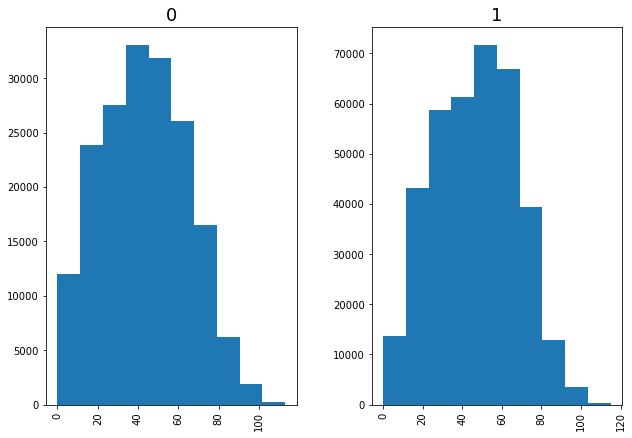

In [44]:
# Look at the distribution of length of tweets in generic dataset, based on each one's sentiment

df_sent['length'] = df_sent['text'].apply(len)

fig = df_sent.hist('length',by='label', figsize=(10, 7))
[x.title.set_size(18) for x in fig.ravel()]

plt.show()

For sentiment dataset, the length of the positive and negative tweets are checked and plotted as histograms shown above. It can be noticed that the length of both positive and negative tweets are slightly skewed towards the left. In general, positive tweets are longer than negative tweets by about 20 words.

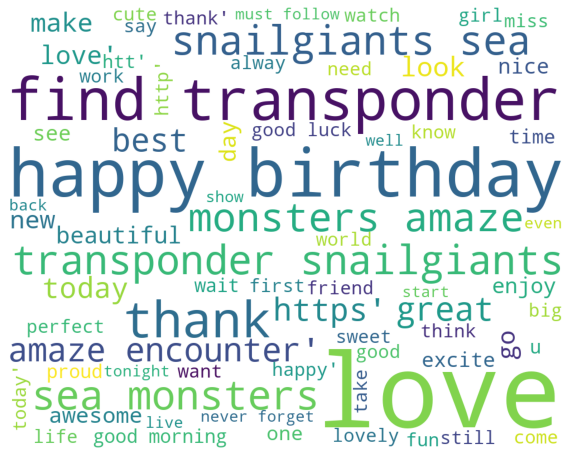

In [186]:
# Look at keywords in tweets with positive sentiment in generic dataset

df_sent_pos = df_sent.loc[df_sent['label']==1] # Select rows with positive sentiment only

# Store all word tokens in a list

content_list = []

for i in range (0, len(df_sent_neg)):
    tokens_text = word_tokenize(df_sent_pos.iloc[i]['text'])
    tokens_hash = word_tokenize(df_sent_pos.iloc[i]['hashtags'])
    content_list.append(' '.join([token for token in tokens_text if token not in tokens_hash]))

content_list = str(content_list)
content_list = ''.join(content_list)

wordcloud = WordCloud(width = 1000, height = 800, background_color='white', max_words=70, random_state=10).generate(content_list)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

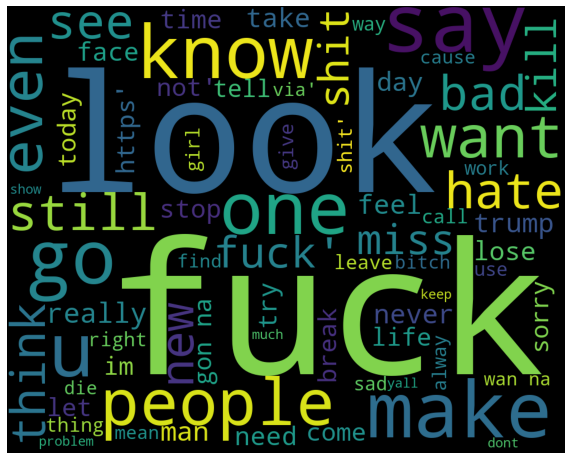

In [45]:
# Look at keywords in tweets with negative sentiment in generic dataset

df_sent_neg = df_sent.loc[df_sent['label']==0] # Select rows with negative sentiment only

# Store all word tokens in a list

content_list = []

for i in range (0, len(df_sent_neg)):
    tokens_text = word_tokenize(df_sent_neg.iloc[i]['text'])
    tokens_hash = word_tokenize(df_sent_neg.iloc[i]['hashtags'])
    content_list.append(' '.join([token for token in tokens_text if token not in tokens_hash]))

content_list = str(content_list)
content_list = ''.join(content_list)

wordcloud = WordCloud(width = 1000, height = 800, background_color='black', max_words=70, random_state=10).generate(content_list)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

A wordcloud for the positive tweets in the generic dataset is shown on the top left in white. Some words with noticeable positive emotions are: happy, love, great, amaze, awesome, good, etc.

Another wordcloud for the negative tweets is generateed. It can be observed that a lot of words express negative emotions (e.g. kill, die, problem, mean, bad, etc.), and some words are even swearing words.

# 3. Model preparation

## 3.1 Feature preparation

Training data and testing data are taken from the sentiment dataset. The splitting is done before vectorizing, because if vectorizing is done first on the whole dataset before splitting, testing features will be memorized and data leakage will happen. 

After splitting, CountVectorizer() is fitted on the training dataset, and is used to transform both the training dataset and the testing dataset into word frequency (WF) vectors. The reason for not fitting on the testing dataset is because the same features learned from the training dataset should be used to transform the testing dataset. 

TfidfVectorizer() is fitted on the training dataset, and is used to transform both the training and testing dataset into tf-idf vectors. The reason for not fitting on the testing dataset is because the same features learned from the training dataset should be used to transform the testing dataset. 

The number of maximum feature for both wf and tf-idf vectors is set to 5000 to avoid excessively long runtime and to retain useful amount of features needed to train the model.

The resulting vectors are all in the form of sparse matrix.

In [46]:
# Split dataset into train and test datasets

X_train, X_test, y_train, y_test = train_test_split(df_sent['text'], df_sent['label'], test_size=0.3, random_state=0)


In [47]:
# Prepare features using Bag of Words (word frequency)

wordfreq = CountVectorizer(max_features=5000, stop_words='english')

X_train_wf = wordfreq.fit_transform(X_train) 
X_test_wf = wordfreq.transform(X_test) 

In [48]:
# Prepare features using TF-IDF

tfidf = TfidfVectorizer(max_features=5000, stop_words='english', use_idf=True, smooth_idf=True)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## 3.2 Logistic regression

LogisticRegression() from scikit learn is used to set up the logistic regression base model. "random_state" is set to 0 to enable shuffling of the data. "max_iter" is set to 1000 in order to acheive convergence and potentially improve accuracy. "dual" is set to "False" because the number of samples is greater than the number of features.

f1 score is chosen as the metrics because it is more suitable for binary classification.

The results indicated that logistic regression model is able to acheive very high accuracy, which may be a sign of overfitting. It can be observed that the word frequency features attain a slightly higher f1 score than the tf-idf features.

In [49]:
#Define logistic regression model

lr_model = LogisticRegression(solver='saga', random_state=0, max_iter = 1000, dual=False)

In [50]:
# Logistic regression using WF

lr_model.fit(X_train_wf, y_train)
pred_lr_wf = lr_model.predict(X_test_wf)
acc_lr_wf = f1_score(y_test, pred_lr_wf)

print("The accuracy is: {0}%".format(round(acc_lr_wf*100,2)))
print(classification_report(y_test, pred_lr_wf))


The accuracy is: 97.09%
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     53707
           1       0.97      0.97      0.97    111411

    accuracy                           0.96    165118
   macro avg       0.95      0.96      0.96    165118
weighted avg       0.96      0.96      0.96    165118



In [51]:
# Logistic regression using tf-idf

lr_model.fit(X_train_tfidf, y_train)
pred_lr_tfidf = lr_model.predict(X_test_tfidf)
acc_lr_tfidf = f1_score(y_test, pred_lr_tfidf)

print("The accuracy is: {0}%".format(round(acc_lr_tfidf*100,2)))
print(classification_report(y_test, pred_lr_tfidf))


The accuracy is: 97.06%
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     53707
           1       0.97      0.97      0.97    111411

    accuracy                           0.96    165118
   macro avg       0.95      0.96      0.96    165118
weighted avg       0.96      0.96      0.96    165118



## 3.3 Decision Trees classifier

DecisionTreeClassifier() from scikit learn is used to set up the Decision Trees base model. "criterion" is set to "gini" in order to potentially reduce runtime. "random_state" is set to 1 to enable shuffling of the data.

f1 score is chosen as the metrics because it is more suitable for binary classification.

The results show that Decision Trees model is able to achieve a fairly high accuracy, which again may be a sign of overfitting. It can be observed that the tf-idf features result in a slightly higher f1 score than the word frequency feature. 

In [52]:
# Define decision tree classifier model

dct_model = DecisionTreeClassifier(criterion='gini', random_state = 1)

In [53]:
# Decision trees using WF

dct_model.fit(X_train_wf, y_train)
pred_dct_wf = dct_model.predict(X_test_wf)
acc_dct_wf = f1_score(y_test, pred_dct_wf)

print("The accuracy is: {0}%".format(round(acc_dct_wf*100,2)))
print(classification_report(y_test, pred_dct_wf))


The accuracy is: 95.16%
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     53707
           1       0.95      0.96      0.95    111411

    accuracy                           0.93    165118
   macro avg       0.93      0.92      0.92    165118
weighted avg       0.93      0.93      0.93    165118



In [54]:
# Decision trees using tf-idf

dct_model.fit(X_train_tfidf, y_train)
pred_dct_tfidf = dct_model.predict(X_test_tfidf)
acc_dct_tfidf = f1_score(y_test, pred_dct_tfidf)

print("The accuracy is: {0}%".format(round(acc_dct_tfidf*100,2)))
print(classification_report(y_test, pred_dct_tfidf))


The accuracy is: 95.37%
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     53707
           1       0.95      0.95      0.95    111411

    accuracy                           0.94    165118
   macro avg       0.93      0.93      0.93    165118
weighted avg       0.94      0.94      0.94    165118



## 3.4 Random Forest classifier

RandomForestClassifier() from scikit learn is used to establish the Random Forest base model. "n_estimators" is set to 100 in order to avoid long runtime. "criterion" is set to "gini" to also potentially reduce runtime. "random_state" is set to 42 to enable shuffling of the data.

f1 score is chosen as the metrics because it is more suitable for binary classification.

The results show that Random Forest model is able to achieve a fairly high accuracy (higher than Decision Trees), which again may be a sign of overfitting. It can be observed that the tf-idf features result in a slightly higher f1 score than the word frequency feature. 

In [55]:
# Define Random Forest classifier model

rf_model = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)

In [56]:
# Random Forest using WF

rf_model.fit(X_train_wf, y_train)
pred_rf_wf = rf_model.predict(X_test_wf)
acc_rf_wf = f1_score(y_test, pred_rf_wf)

print("The accuracy is: {0}%".format(round(acc_rf_wf*100,2)))
print(classification_report(y_test, pred_rf_wf))


The accuracy is: 96.39%
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     53707
           1       0.96      0.97      0.96    111411

    accuracy                           0.95    165118
   macro avg       0.95      0.94      0.94    165118
weighted avg       0.95      0.95      0.95    165118



In [57]:
# Random Forest using tf-idf

rf_model.fit(X_train_tfidf, y_train)
pred_rf_tfidf = rf_model.predict(X_test_tfidf)
acc_rf_tfidf = f1_score(y_test, pred_rf_tfidf)

print("The accuracy is: {0}%".format(round(acc_rf_tfidf*100,2)))
print(classification_report(y_test, pred_rf_tfidf))


The accuracy is: 96.54%
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     53707
           1       0.96      0.97      0.97    111411

    accuracy                           0.95    165118
   macro avg       0.95      0.95      0.95    165118
weighted avg       0.95      0.95      0.95    165118



## 3.5 KNN classifier

KNeighborsClassifier() from scikit learn is used to establish the KNN base model. "n_estimators" is set to 620 based on the rule of thumb - number of neighbors = sqrt(number of samples).

f1 score is chosen as the metrics because it is more suitable for binary classification.

The results show that Random Forest model results in the lowest accuracy so far. It can be observed that the tf-idf features result in a very low f1 score.

In [58]:
# Define KNN classifier model

knn_model = KNeighborsClassifier(n_neighbors = 620) # rule of thumb: number of neighbors = sqrt(number of samples)

In [59]:
# KNN using WF

knn_model.fit(X_train_wf, y_train)
pred_knn_wf = knn_model.predict(X_test_wf)
acc_knn_wf = f1_score(y_test,pred_knn_wf)

print("The accuracy is: {0}%".format(round(acc_knn_wf*100,2)))
print(classification_report(y_test, pred_knn_wf))


The accuracy is: 85.81%
              precision    recall  f1-score   support

           0       0.66      0.96      0.79     53707
           1       0.98      0.76      0.86    111411

    accuracy                           0.83    165118
   macro avg       0.82      0.86      0.82    165118
weighted avg       0.88      0.83      0.83    165118



In [60]:
# KNN using tf-idf

knn_model.fit(X_train_tfidf, y_train)
pred_knn_tfidf = knn_model.predict(X_test_tfidf)
acc_knn_tfidf = f1_score(y_test,pred_knn_tfidf)

print("The accuracy is: {0}%".format(round(acc_knn_tfidf*100,2)))
print(classification_report(y_test, pred_knn_tfidf))


The accuracy is: 36.45%
              precision    recall  f1-score   support

           0       0.38      0.99      0.55     53707
           1       0.98      0.22      0.36    111411

    accuracy                           0.47    165118
   macro avg       0.68      0.61      0.46    165118
weighted avg       0.79      0.47      0.42    165118



## 3.6 Linear SVC

LinearSVC() from scikit learn is used to establish the SVM base model instead of SVC() because LinearSVC() tends to converge faster. "random_state" is set to 42 to enable shuffling of the data. "max_iter" is set to 10000 in order to achieve convergence and potentially improve accuracy. "loss" is sent to "hinge" so that it uses the same loss function as SVC().

f1 score is chosen as the metrics because it is more suitable for binary classification.

The results show that Random Forest model is able to achieve a very high accuracy, which may be a sign of overfitting. It can be observed that the tf-idf features result in a slightly higher f1 score than the word frequency feature. 

In [61]:
# Define Linear SVC model

svc_model = LinearSVC(random_state = 0, max_iter = 10000, loss='hinge')

In [62]:
# Linear SVC using WF

svc_model.fit(X_train_wf, y_train)
pred_svc_wf = svc_model.predict(X_test_wf)
acc_svc_wf = f1_score(y_test,pred_svc_wf)

print("The accuracy is: {0}%".format(round(acc_svc_wf*100,2)))
print(classification_report(y_test, pred_svc_wf))


The accuracy is: 97.06%
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     53707
           1       0.98      0.97      0.97    111411

    accuracy                           0.96    165118
   macro avg       0.95      0.96      0.96    165118
weighted avg       0.96      0.96      0.96    165118



In [63]:
# Linear SVC using tf-idf

svc_model.fit(X_train_tfidf, y_train)
pred_svc_tfidf = svc_model.predict(X_test_tfidf)
acc_svc_tfidf = f1_score(y_test,pred_svc_tfidf)

print("The accuracy is: {0}%".format(round(acc_svc_tfidf*100,2)))
print(classification_report(y_test, pred_svc_tfidf))


The accuracy is: 97.08%
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     53707
           1       0.97      0.97      0.97    111411

    accuracy                           0.96    165118
   macro avg       0.95      0.96      0.96    165118
weighted avg       0.96      0.96      0.96    165118



## 3.7 Naive Bayes classifier

ComplementNB() from scikit learn is used to establish the Naive Bayes base model. Complement Naive Bayes is the adaptation of the standard multinomial naive bayes, which is commonly used for text classification. Complement NB is different from multiomial NB in that it is more suitable for imbalanced dataset. It can be observed that from the classification report, the dataset contains more class 1 and is therefore imbalanced. 

f1 score is chosen as the metrics because it is more suitable for binary classification.

The results show that complement Naive Bayes model is able to achieve a very high accuracy, which may be a sign of overfitting. It can be observed that the tf-idf features result in a slightly higher f1 score than the word frequency feature. 

In [64]:
# Define complement naive bayes model

cnb_model = ComplementNB()

In [65]:
# Complement naive bayes using WF

cnb_model.fit(X_train_wf, y_train)
pred_cnb_wf = cnb_model.predict(X_test_wf)
acc_cnb_wf = f1_score(y_test,pred_cnb_wf)

print("The accuracy is: {0}%".format(round(acc_cnb_wf*100,2)))
print(classification_report(y_test, pred_cnb_wf))


The accuracy is: 95.49%
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     53707
           1       0.97      0.94      0.95    111411

    accuracy                           0.94    165118
   macro avg       0.93      0.94      0.93    165118
weighted avg       0.94      0.94      0.94    165118



In [66]:
# Complement naive bayes using tf-idf

cnb_model.fit(X_train_tfidf, y_train)
pred_cnb_tfidf = cnb_model.predict(X_test_tfidf)
acc_cnb_tfidf = f1_score(y_test,pred_cnb_tfidf)

print("The accuracy is: {0}%".format(round(acc_cnb_tfidf*100,2)))
print(classification_report(y_test, pred_cnb_tfidf))


The accuracy is: 94.55%
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     53707
           1       0.97      0.93      0.95    111411

    accuracy                           0.93    165118
   macro avg       0.91      0.93      0.92    165118
weighted avg       0.93      0.93      0.93    165118



## 3.8 XGBoost classifier

XGBClassifier() from XGBoost  is used to establish the XGBoost base model. "max_depth" is set to 3 to reduce model complexity and potentially reduce likelihood of overfitting. "random_state" is set to 0 to enable shuffling of the dta.

f1 score is chosen as the metrics because it is more suitable for binary classification.

The results show that XGBoost model is able to achieve a high accuracy (although lower than most other models in this section). It can be observed that the tf-idf features result in a slightly higher f1 score than the word frequency feature. 

In [67]:
import sys
!{sys.executable} -m pip install xgboost

In [68]:
import xgboost as xgb
from xgboost import XGBClassifier

In [69]:
# Define XGBclassifier model

xgb_model = XGBClassifier(max_depth=3, random_state = 0)

In [70]:
# XGBclassifier using WF

xgb_model.fit(X_train_wf, y_train)
pred_xgb_wf = xgb_model.predict(X_test_wf)
acc_xgb_wf = f1_score(y_test,pred_xgb_wf)

print("The accuracy is: {0}%".format(round(acc_xgb_wf*100,2)))
print(classification_report(y_test, pred_xgb_wf))


The accuracy is: 92.21%
              precision    recall  f1-score   support

           0       0.78      0.96      0.86     53707
           1       0.98      0.87      0.92    111411

    accuracy                           0.90    165118
   macro avg       0.88      0.92      0.89    165118
weighted avg       0.91      0.90      0.90    165118



In [71]:
# XGBclassifier using tf-idf

xgb_model.fit(X_train_tfidf, y_train)
pred_xgb_tfidf = xgb_model.predict(X_test_tfidf)
acc_xgb_tfidf = f1_score(y_test,pred_xgb_tfidf)

print("The accuracy is: {0}%".format(round(acc_xgb_tfidf*100,2)))
print(classification_report(y_test, pred_xgb_tfidf))


The accuracy is: 92.22%
              precision    recall  f1-score   support

           0       0.78      0.96      0.86     53707
           1       0.98      0.87      0.92    111411

    accuracy                           0.90    165118
   macro avg       0.88      0.92      0.89    165118
weighted avg       0.91      0.90      0.90    165118



# 4. Model implementation & hyperparameter tuning

## 4.1 Implement the best model on validation dataset

As shown above in Section 3.2 - Section 3.8, the best model with the highest accuracy is logistic regression using word frequency, which yields an accuracy score of 97.09%. Therefore, logistic regression with word frequency is chosen to be implemented on the Canadian election dataset, using the same word features learned from the sentiment dataset.

Before implementing the best model, numeric class labels are added to the original election dataset using the function defined below. To make sure the class labels are consistent with the training dataset, 0 is assigned to tweets with negative sentiment and 1 is assigned to tweets with positive sentiment.

In [72]:
# Define a function to create numeric labels for the sentiment of each tweet

def label_creator(text):
    if text == 'negative':
        return 0
    else:
        return 1


In [73]:
# Create binary label for the Canadian election dataset

df_elec['label'] = df_elec['sentiment'].apply(label_creator)
df_elec

,sentiment,negative_reason,text,hashtags,Party,label
0,negative,Women Reproductive right and Racism,instead suggestion agree canadian women not no...,canadian women andrewscheer conservatives cdnp...,conservatives,0
1,positive,NaN,allwomanspacewalk real etobicokenorth cityofto...,allwomanspacewalk etobicokenorth cityofto onpo...,other/unknown,1
2,negative,Economy,brantford go cost 94 billion next 4 years ask ...,brantford elxn43 cdnpoli canada,other/unknown,0
3,positive,NaN,canada canadaelection2019 canadavotes elxn43 n...,canada canadaelection2019 canadavotes elxn43,other/unknown,1
4,negative,Economy,canada taxpayers sick tire hard earn donate ...,canada taxpayers trudeaumustgo canada snclaval...,conservatives,0
...,...,...,...,...,...,...
2128,negative,Scandal,know good enough job smear campaign right cdnp...,cdnpoli elxn43,other/unknown,0
2129,negative,Scandal,miss comment deflect issue not answer best res...,cdnpoli elxn2019 elxn43 canadavotes,other/unknown,0
2130,positive,NaN,daily reminder endorse strategic vote elxn43 e...,elxn43 elxn2019 cdnpoli lpc ndp gpc,liberal,1
2131,negative,Women Reproductive right and Racism,yup not go reopen abortion debate elxn43 schee...,elxn43 scheerlies scheerhypocrisy,other/unknown,0


In [74]:
# Vectorize the Canadian election text using WF, using features from the training set

X_valid_wf = wordfreq.transform(df_elec['text'])

In [83]:
#Define logistic regression model

lr_model = LogisticRegression(solver='saga', random_state=0, max_iter = 1000, dual=False)

# Logistic regression using WF

lr_model.fit(X_train_wf, y_train)
valid_pred_lr_wf = lr_model.predict(X_valid_wf)
valid_acc_lr_wf = f1_score(df_elec['label'], valid_pred_lr_wf)

print("The accuracy is: {0}%".format(round(valid_acc_lr_wf*100,2)))
print(classification_report(df_elec['label'], valid_pred_lr_wf))

The accuracy is: 53.4%
              precision    recall  f1-score   support

           0       0.56      0.83      0.67      1006
           1       0.74      0.42      0.53      1127

    accuracy                           0.61      2133
   macro avg       0.65      0.63      0.60      2133
weighted avg       0.66      0.61      0.60      2133



In [84]:
# Store the prediction in the dataframe

df_elec['prediction'] = valid_pred_lr_wf

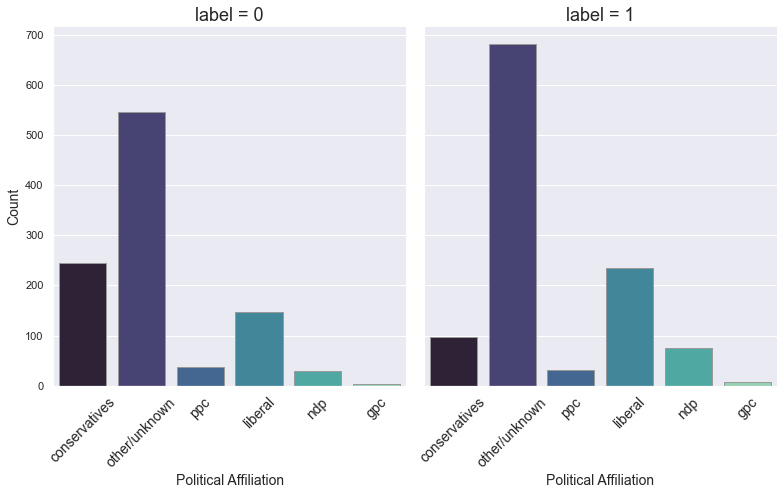

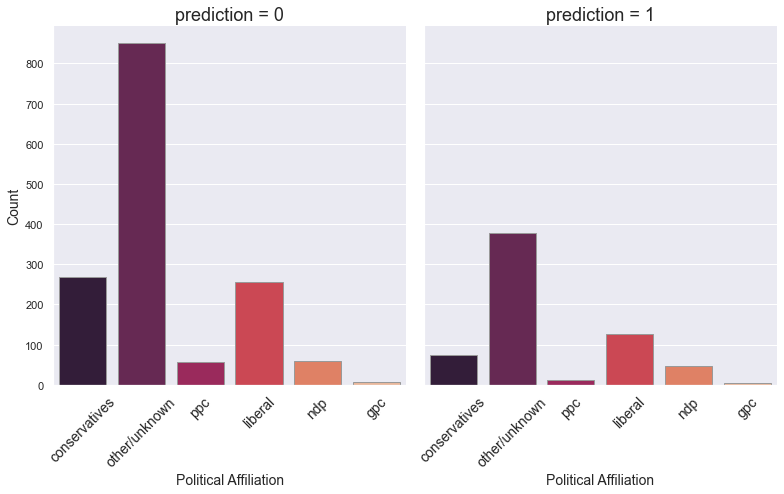

In [98]:
# Visualize the true labels and predicted labels

df_elec_true = df_elec[['Party','label']]
df_elec_pred = df_elec[['Party','prediction']]

# Plot using seaborn
#fig,ax = plt.subplots(2)
sns.set(style='darkgrid')

g = sns.catplot(ax = ax[0], data = df_elec_true, x='Party', kind="count", col='label', height = 6, aspect=.9, palette="mako", edgecolor=".6")
g.set_xticklabels(size = 14, rotation = 45)
g.set_xlabels("Political Affiliation", size = 14)
g.set_ylabels("Count", size = 14)
g.set_titles(size = 18)

g1 = sns.catplot(ax = ax[1], data = df_elec_pred, x='Party', kind="count", col='prediction', height = 6, aspect=.9, palette="rocket", edgecolor=".6")
g1.set_xticklabels(size = 14, rotation = 45)
g1.set_xlabels("Political Affiliation", size = 14)
g1.set_ylabels("Count", size = 14)
g1.set_titles(size = 18)
import warnings
warnings.filterwarnings("ignore")
plt.show()


The validation accuracy is significantly lower than the training accuracy, indicating that the model is overfitting. As shown in the plots above, the model did a fairly good job predicting sentiment of tweets related to the Conservative Party. However, the model noticeably assign more "Other/Unknown" tweets with negative sentiment, whereas in the true data, more "Other/Unknown" tweets have positive sentiment. Same results are observed with "ppc" tweets, "liberal" tweets, "ndp" tweets and "gpc " tweets - the model tends to assign negative sentiment to these tweets whereas in the true data, more of these tweets have positive sentiment. 

Based on the results above, it is deemed that NLP analytics based on tweets is useful to some degree but not entirely reliable. NLP analytics above is able to predict sentiment for some tweets and can provide a rough high-level overview of sentiment towards each political party. However, if the goal is to predict which party will win the election, the analytics above is not reliable as it tends to assign negative sentiment to the validatin tweets. To improve accuracy of the model the following recommendations could be considered:

1) Use an exhaustive/more complete list of stopwords to reduce potential noises

2) Increase training data

3) Moderately increase the number of features so that the likelihood of excluding low-frequency words is reduced and at the same time the model will not result in an excessively long runtime

4) Use more sophisticated feature engineering techniques such as N-grams

## 4.2 Preprocess data with negative sentiment

For preprocessing the election tweets with negative sentiment, all class categories are examined, as shown below.

In [99]:
# Make a dataframe that only contains negative election data

df_elec_neg = df_elec[df_elec['sentiment']== 'negative']

In [100]:
# Check how many classes exist for negative reason

df_elec_neg['negative_reason'].value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

It is noticed that the last two categories - "healthcare" and "healthcare and marijuana" - sound similar and each contains a very small number of tweets. To check if it is possible to merge these two categories, a short exploratory analysis is performed below.

In [101]:
# Check to see if there is a need to merge "healthcare" and "healthcare and marijuana"

df_elec_neg[df_elec_neg['negative_reason']=='Healthcare and Marijuana']['text']

993     anything govt grant i m gonna apply test peopl...
1317    every province force sell trudeau weed lose mo...
1766    reminder undecided vote leave elxn43 95 years ...
1850    that s chuck rifici cfo liberal party canada p...
Name: text, dtype: object

In [102]:
# Check to see if there is a need to merge "healthcare" and "healthcare and marijuana"

df_elec_neg[df_elec_neg['negative_reason']=='Healthcare']['text']

53      coalition gov not might get us evidencebased p...
292     healthcare life support yet absent election ti...
536     not next prime minister canada dentalcare bad ...
1710    individual medical right freedoms strip away v...
2076    many people want guy pm prove underhanded liar...
Name: text, dtype: object

In [103]:
# Check to see if there is a need to merge "healthcare" and "healthcare and marijuana"

df_elec_neg.loc[1317]['text']

'every province force sell trudeau weed lose money every weed company lose money trudeau can t even get sell pot right verdict year one legalize cannabis canada dud elxn43 cdnpoli'

In [104]:
# Check to see if there is a need to merge "healthcare" and "healthcare and marijuana"

df_elec_neg.loc[2076]['text']

'many people want guy pm prove underhanded liar no intention transparent canadians promise cut healthcare infrastructure mean fewer job people see cdnelxn2019 elxn43'

After manually checking some tweets related to "healthcare" and "healthcare and marijuana", it is noticed that these two categories contain certain keywords that are very representative and distinct (e.g. healthcare infrastructure, dental care vs. weed, pot). Therefore it is decided not to merge these two classes.

To make these data usable, numeric class labels are created for each class using the function defined below. There are 10 classes in total and therefore this is a multi-class classification problem. The class labels range from 0 - 9, and the corresponding negative reason of each label is shown below.

In [105]:
# Create numeric labels for the 10 negative reasons

def multiclass_labeler(text):
    if text == 'Others':
        return 0
    elif text == 'Scandal':
        return 1
    elif text == 'Tell lies':
        return 2
    elif text == 'Economy':
        return 3
    elif text == 'Women Reproductive right and Racism':
        return 4
    elif text == 'Climate Problem':
        return 5
    elif text == 'Separation':
        return 6
    elif text == 'Privilege':
        return 7
    elif text == 'Healthcare':
        return 8
    else:
        return 9



In [106]:
# Create numeric target variable

df_elec_neg['target'] = df_elec_neg['negative_reason'].apply(multiclass_labeler)


In [107]:
# Split dataset into train and test datasets

X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(df_elec_neg['text'], df_elec_neg['target'], test_size=0.3, random_state=0)


For feature preparation, word embedding is used in addition to word frequency. For word embedding, SpaCy library and its existing library (en_core_web_lg) are used. SpaCy has a default feature dimension of 300 for each word. And it outputs word vectors on a sentence level, meaning that SpaCy calculates the average vectors of all words in the sentence, and the resulting vector for each sentence has a length of 300. It can be noticed that the resulting vectors contain negative values.

In [108]:
# Prepare features using Bag of Words (word frequency)

wordfreq = CountVectorizer(max_features=5000, stop_words='english')

X_train_neg_wf = wordfreq.fit_transform(X_train_neg) 
X_test_neg_wf = wordfreq.transform(X_test_neg) 

In [109]:
# Prepare features using word embedding

!pip install -U pip setuptools wheel
!pip3 install spacy
!pip install -U spacy
!python3 -m spacy download en_core_web_lg

     |████████████████████████████████| 778.8 MB 23 kB/s s eta 0:00:01    |███▎                            | 80.9 MB 39.1 MB/s eta 0:00:18     |████▌                           | 108.5 MB 54.9 MB/s eta 0:00:13     |█████▌                          | 133.7 MB 16.7 MB/s eta 0:00:39     |█████▊                          | 138.6 MB 16.7 MB/s eta 0:00:39     |██████▍                         | 156.5 MB 20.8 MB/s eta 0:00:30     |███████                         | 167.9 MB 14.1 MB/s eta 0:00:44     |███████                         | 172.8 MB 14.1 MB/s eta 0:00:44     |███████▎                        | 176.8 MB 14.1 MB/s eta 0:00:43     |██████████▍                     | 251.8 MB 43.1 MB/s eta 0:00:13     |███████████▋                    | 283.0 MB 43.1 MB/s eta 0:00:12     |████████████▉                   | 312.2 MB 11.0 MB/s eta 0:00:43     |█████████████████▎              | 420.2 MB 31.2 MB/s eta 0:00:12     |█████████████████▋              | 428.0 MB 31.2 MB/s eta 0:00:12     |████████████████

In [110]:
import spacy 

# Import word vector library

nlp = spacy.load('en_core_web_lg')

In [111]:
# Define dataframes to be used for data preprocessing for using spacy

df_X_train = pd.DataFrame(X_train_neg)
df_X_test = pd.DataFrame(X_test_neg)

In [112]:
# Vectorizing each sample in the train dataset (resulting vectors are the averaged vectors, size = 300)

xtrain_list = df_X_train['text'].apply(lambda text: nlp(text).vector)
df_X_train['vectors'] = xtrain_list

# Split vector arryas into list

veclist_train=df_X_train['vectors'].values.tolist()

# Convert to a dataframe
df_X_train_vec = pd.DataFrame(veclist_train,index=df_X_train.index)
df_X_train_vec

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
866,-0.106269,0.109047,0.037389,0.000811,0.049058,0.016592,0.086266,-0.153726,0.030693,0.482112,...,0.085932,0.059539,-0.023655,-0.115033,0.135735,0.010738,-0.053165,0.001807,-0.150109,0.075807
1368,-0.105375,0.179228,0.079418,0.053526,-0.030752,-0.009226,-0.012701,-0.006653,0.093119,1.354692,...,-0.085575,-0.042268,0.044358,-0.037788,0.063725,0.003018,-0.083154,-0.060210,-0.073978,-0.050859
797,-0.067509,0.182681,-0.184721,-0.043721,0.055678,0.106758,0.050868,-0.202693,-0.000453,1.518725,...,-0.095543,-0.058788,-0.168289,-0.069336,0.245364,-0.049291,-0.014860,-0.093026,0.043297,0.008391
468,0.026859,0.092632,-0.066834,0.009788,0.142244,-0.000003,-0.057076,0.023779,0.044761,1.706886,...,-0.202561,0.028619,-0.028082,-0.142890,0.028558,-0.093386,-0.040262,-0.033302,0.014970,0.061885
1039,-0.102525,0.049336,-0.013178,-0.056532,0.135843,-0.027563,0.019571,-0.016724,0.039243,1.854502,...,-0.122128,0.031026,-0.020577,-0.095298,0.061207,0.026901,-0.064494,-0.094794,0.083970,0.105406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,-0.263154,-0.027911,0.001296,-0.037464,-0.078097,-0.040178,0.106617,0.044812,-0.011675,1.371887,...,-0.140101,0.021380,-0.102906,-0.035438,0.116499,0.059314,-0.065507,-0.099826,-0.036183,-0.040856
341,0.015309,0.055077,-0.066325,-0.095122,0.217489,0.065631,-0.005706,-0.121836,0.111009,1.071257,...,-0.059249,0.033276,0.043555,-0.049023,-0.013097,-0.081996,-0.007532,-0.076544,-0.098431,0.138168
1180,0.039763,-0.115918,-0.065604,0.138778,-0.013645,0.127998,-0.110105,0.051805,-0.063359,0.961433,...,-0.108080,0.197352,-0.013020,-0.078886,-0.092732,-0.144628,-0.028754,0.060665,0.126477,0.057039
1017,-0.009255,0.188146,-0.112335,-0.009241,-0.036050,-0.096478,0.141331,-0.078220,-0.030175,2.129627,...,-0.023284,0.022912,-0.105515,-0.170055,0.206818,-0.006056,-0.075321,-0.040426,0.231025,0.044596


In [113]:
# Vectorizing each sample in the test dataset (resulting vectors are the averaged vectors, size = 300)

xtest_list = df_X_test['text'].apply(lambda text: nlp(text).vector)
df_X_test['vectors'] = xtest_list

# Split vector arryas into list

veclist_test=df_X_test['vectors'].values.tolist()

# Convert to a dataframe
df_X_test_vec = pd.DataFrame(veclist_test,index=df_X_test.index)
df_X_test_vec

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1404,-0.198654,0.057223,0.077163,0.036066,-0.039406,0.033082,-0.033488,-0.030218,0.011363,1.673028,...,-0.162429,0.099699,0.061120,-0.088842,0.109211,0.011551,-0.074633,-0.101215,0.052266,-0.052009
1276,-0.012310,0.050648,-0.142212,0.072069,0.046777,-0.051126,0.003833,-0.122563,0.033129,2.118439,...,-0.064189,-0.073557,0.006413,-0.095029,0.077442,-0.177378,0.106805,-0.027668,-0.013649,-0.004436
552,0.071220,0.024475,0.024378,0.124191,-0.099887,-0.194442,-0.117520,0.126205,0.006202,1.126317,...,0.029827,0.032119,-0.069560,-0.011931,-0.068307,0.098353,-0.059937,-0.110154,0.061312,-0.095512
670,-0.249720,0.110547,-0.069366,-0.093231,0.029150,0.173226,0.069661,-0.222161,0.121491,1.229504,...,0.070354,-0.058698,-0.261324,-0.183866,0.278170,0.037529,0.019897,-0.012436,0.092843,0.087917
1046,-0.227899,0.193857,-0.097038,-0.092428,0.003236,0.024843,-0.047892,-0.063887,0.073543,2.065950,...,-0.256571,0.067286,-0.208958,-0.064631,0.194526,0.059571,-0.109549,-0.110383,0.078049,-0.019723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,-0.151118,0.058491,-0.076449,-0.026405,-0.103716,-0.062981,-0.025238,-0.112739,0.027832,2.072056,...,-0.203771,-0.006146,-0.014998,-0.005523,0.143022,-0.102888,-0.110880,-0.128549,0.128250,0.106106
769,-0.057241,0.052902,0.058662,-0.003692,0.188907,0.015815,-0.122683,-0.063347,0.117885,1.680078,...,-0.116596,0.041054,0.050188,-0.080083,0.045053,-0.014866,-0.143262,-0.045347,-0.084512,0.061062
21,-0.098412,0.064168,-0.094981,-0.059260,0.033149,-0.067820,0.017997,-0.131264,-0.011295,1.669029,...,-0.057017,-0.022782,-0.002190,-0.094459,0.067587,-0.026302,-0.078650,-0.123190,0.026434,0.070922
168,-0.128056,0.082987,-0.059546,-0.039801,0.065654,-0.066103,-0.037704,-0.101016,0.033464,1.847331,...,-0.127981,0.045146,-0.154773,-0.117792,0.124754,0.018688,-0.068583,-0.014566,0.105124,0.004277


## 4.3 Model implementation and tuning

## 4.31 Logistic regression

For this section, logistic regression, linear SVC and Random Forest are chosen as they yield the highest accuracy in section 3.

Logistic regression model is defined as below, with some modifications based on the base model in section 3. "penalty" is set to "elasticnet" to allow for the combination of both l1 and l2 regularization and tuning of the regularization strength C. "max_iter" is increased to 3000 in order to achieve convergence. "multi_class" is set to "multinomial" as this is a multi-class classification problem. "class_weight" is set to "balanced" to help adjust the imbalance among classes as the original dataset contains a much larger amount of class 0, 1 and 2.

Two hyperparameters are chosen here, namely "C" and "l1_ratio". "C" changes the regularization strength. "l1_ratio" changes the ratio of l1 and l2 regularization. A range of values for each hyperparameter is defined as below. The default penalty for logistic regression is l2, which corresponds to a l1_ratio of 0. Therefore 0 is not included in the list of l1_ratio values to be tested.

Accuracy score is chosen as the metrics to select the best model as it is more suitable for multi-class classification problems. GridSearchCV is used to tune hyperparameters, as shown below. The cross-validation fold is set to 5, which is also the default, to avoid excessively long runtime.

Based on the results, word embedding yields a slightly higher frequency, with the model parameters being the follwoing: C=10, class_weight='balanced', l1_ratio=0.2, max_iter=3000, multi_class='multinomial', penalty='elasticnet', random_state=0, solver='saga'.

In [114]:
# Define logistic regression model

lr_model = LogisticRegression(solver='saga', penalty='elasticnet',
                              random_state=0, max_iter=3000, multi_class='multinomial',
                             class_weight='balanced', dual=False)

# Define hyperparameters to be tuned

params_lr = {'C':[0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'l1_ratio':[0.2, 0.4, 0.8, 1]}

# Compare parameters by accuracy score of the model 

scorer_lr = make_scorer(accuracy_score)

In [115]:
# Logistic regression using WF

lr_wf_gridsearch = GridSearchCV(lr_model, params_lr, scoring=scorer_lr, cv=KFold(n_splits=5)).fit(X_train_neg_wf, y_train_neg)
lr_best_wf = lr_wf_gridsearch.best_estimator_

pred_lr_neg_wf = lr_best_wf.predict(X_train_neg_wf)
acc_lr_neg_wf = accuracy_score(y_train_neg, pred_lr_neg_wf)

print("The accuracy is: {0}% \n".format(round(acc_lr_neg_wf*100,2)))
print(classification_report(y_train_neg, pred_lr_neg_wf),"\n")
print(lr_best_wf)



The accuracy is: 86.65% 

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       249
           1       0.83      0.85      0.84       178
           2       0.90      0.77      0.83       144
           3       0.97      1.00      0.98        32
           4       0.97      1.00      0.99        38
           5       0.97      1.00      0.98        31
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3

    accuracy                           0.87       704
   macro avg       0.95      0.95      0.95       704
weighted avg       0.87      0.87      0.87       704
 

LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.4, max_iter=3000,
                   multi_class='multinomial', penalty='elasticnet',
                   random_state=0, solver='saga')


In [116]:
# Logistic regression using word embedding

lr_we_gridsearch = GridSearchCV(lr_model, params_lr, scoring=scorer_lr, cv=KFold(n_splits=5)).fit(df_X_train_vec, y_train_neg)
lr_best_we = lr_we_gridsearch.best_estimator_

pred_lr_neg_we = lr_best_we.predict(df_X_train_vec)
acc_lr_neg_we = accuracy_score(y_train_neg, pred_lr_neg_we)

print("The accuracy is: {0}% \n".format(round(acc_lr_neg_we*100,2)))
print(classification_report(y_train_neg, pred_lr_neg_we),"\n")
print(lr_best_we)



The accuracy is: 87.93% 

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       249
           1       0.87      0.87      0.87       178
           2       0.89      0.87      0.88       144
           3       0.78      1.00      0.88        32
           4       0.95      1.00      0.97        38
           5       0.91      1.00      0.95        31
           6       0.76      1.00      0.87        13
           7       0.85      1.00      0.92        11
           8       1.00      1.00      1.00         5
           9       0.75      1.00      0.86         3

    accuracy                           0.88       704
   macro avg       0.87      0.96      0.91       704
weighted avg       0.88      0.88      0.88       704
 

LogisticRegression(C=10, class_weight='balanced', l1_ratio=0.2, max_iter=3000,
                   multi_class='multinomial', penalty='elasticnet',
                   random_state=0, solver='saga')


## 4.32 Linear SVC

Linear SVC model is defined as below, with some modifications based on the base model in section 3. "class_weight" is set to "balanced" to help adjust the imbalance among classes. "multi_class" is set to "ovr" as this is a multi-class classification problem. 

One hyperparameter is chosen here, namely "C". The default penalty is l2 and "C" changes the regularization strength of l2 penalty.

Accuracy score is chosen as the metrics to select the best model as it is more suitable for multi-class classification problems. GridSearchCV is used to tune hyperparameters, as shown below. The cross-validation fold is set to 5, which is also the default, to avoid excessively long runtime.

Based on the results, word frequency yields a slightly higher frequency, with the model parameters being the follwoing: C=0.5, class_weight='balanced', loss='hinge', max_iter=10000, random_state=0.

In [126]:
# Define Linear SVC model

svc_model = LinearSVC(class_weight='balanced', loss='hinge', random_state = 0, max_iter = 10000, multi_class='ovr')

# Define hyperparameters to be tuned

params_svc = {'C':[0.001, 0.01, 0.05, 0.1, 0.5, 1,5, 10, 100]}

# Compare parameters by accuracy score of the model 

scorer_svc = make_scorer(accuracy_score)

In [127]:
# SVC using WF

svc_wf_gridsearch = GridSearchCV(svc_model, params_svc, scoring=scorer_svc, cv=KFold(n_splits=5)).fit(X_train_neg_wf, y_train_neg)
svc_best_wf = svc_wf_gridsearch.best_estimator_

pred_svc_neg_wf = svc_best_wf.predict(X_train_neg_wf)
acc_svc_neg_wf = accuracy_score(y_train_neg, pred_svc_neg_wf)

print("The accuracy is: {0}% \n".format(round(acc_svc_neg_wf*100,2)))
print(classification_report(y_train_neg, pred_svc_neg_wf),"\n")
print(svc_best_wf)


The accuracy is: 99.57% 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       249
           1       0.99      0.99      0.99       178
           2       1.00      0.99      0.99       144
           3       1.00      1.00      1.00        32
           4       1.00      1.00      1.00        38
           5       1.00      1.00      1.00        31
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3

    accuracy                           1.00       704
   macro avg       1.00      1.00      1.00       704
weighted avg       1.00      1.00      1.00       704
 

LinearSVC(C=0.5, class_weight='balanced', loss='hinge', max_iter=10000,
          random_state=0)


In [128]:
# SVC using word embedding

svc_we_gridsearch = GridSearchCV(svc_model, params_svc, scoring=scorer_svc, cv=KFold(n_splits=5)).fit(df_X_train_vec, y_train_neg)
svc_best_we = svc_we_gridsearch.best_estimator_

pred_svc_neg_we = svc_best_we.predict(df_X_train_vec)
acc_svc_neg_we = accuracy_score(y_train_neg, pred_svc_neg_we)

print("The accuracy is: {0}% \n".format(round(acc_svc_neg_we*100,2)))
print(classification_report(y_train_neg, pred_svc_neg_we),"\n")
print(svc_best_we)


The accuracy is: 88.64% 

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       249
           1       0.89      0.85      0.87       178
           2       0.91      0.88      0.89       144
           3       0.82      0.97      0.89        32
           4       0.90      1.00      0.95        38
           5       1.00      1.00      1.00        31
           6       0.81      1.00      0.90        13
           7       0.79      1.00      0.88        11
           8       0.56      1.00      0.71         5
           9       0.50      1.00      0.67         3

    accuracy                           0.89       704
   macro avg       0.81      0.96      0.86       704
weighted avg       0.89      0.89      0.89       704
 

LinearSVC(C=10, class_weight='balanced', loss='hinge', max_iter=10000,
          random_state=0)


## 4.33 Random Forest classifier

Random Forest model is defined as below.

Two hyperparameters are chosen here, namely "n_estimators" and "max_depth". "n_estimators" defines the number of trees in the model. "max_depth" controls the depth each tree can grow in the model. "class_weight" is set to "balanced" to help adjust the imbalance among classes. A range of values are defined for each hyperparameter, as shown below. 

Accuracy score is chosen as the metrics to select the best model as it is more suitable for multi-class classification problems. GridSearchCV is used to tune hyperparameters, as shown below. The cross-validation fold is set to 5, which is also the default, to avoid excessively long runtime.

Based on the results, word embedding yields a very high frequency (which could be a sign of overfitting), with the model parameters being the follwoing: max_depth=20, n_estimators=800, random_state=42.

In [134]:
# Define Random Forest classifier model

rf_model = RandomForestClassifier(criterion = 'gini', class_weight='balanced', random_state = 42)

# Define hyperparameters to be tuned

params_rf = {'n_estimators': [200, 400, 600, 800, 1000],
            'max_depth': [20, 40, 60, 80, 100, None]}
             
# Compare parameters by accuracy score of the model 

scorer_rf = make_scorer(accuracy_score)

In [130]:
# Random forest using WF

rf_wf_gridsearch = GridSearchCV(rf_model, params_rf, scoring=scorer_rf, cv=KFold(n_splits=5)).fit(X_train_neg_wf, y_train_neg)
rf_best_wf = rf_wf_gridsearch.best_estimator_

pred_rf_neg_wf = rf_best_wf.predict(X_train_neg_wf)
acc_rf_neg_wf = accuracy_score(y_train_neg, pred_rf_neg_wf)

print("The accuracy is: {0}% \n".format(round(acc_rf_neg_wf*100,2)))
print(classification_report(y_train_neg, pred_rf_neg_wf),"\n")
print(rf_best_wf)


The accuracy is: 93.61% 

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       249
           1       0.98      0.93      0.95       178
           2       0.99      0.82      0.90       144
           3       1.00      0.97      0.98        32
           4       1.00      0.97      0.99        38
           5       1.00      0.94      0.97        31
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3

    accuracy                           0.94       704
   macro avg       0.98      0.96      0.97       704
weighted avg       0.94      0.94      0.94       704
 

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=600,
                       random_state=42)


In [135]:
# Random forest using word embedding

rf_we_gridsearch = GridSearchCV(rf_model, params_rf, scoring=scorer_rf, cv=KFold(n_splits=5)).fit(df_X_train_vec, y_train_neg)
rf_best_we = rf_we_gridsearch.best_estimator_

pred_rf_neg_we = rf_best_we.predict(df_X_train_vec)
acc_rf_neg_we = accuracy_score(y_train_neg, pred_rf_neg_we)

print("The accuracy is: {0}% \n".format(round(acc_rf_neg_we*100,2)))
print(classification_report(y_train_neg, pred_rf_neg_we),"\n")
print(rf_best_we)


The accuracy is: 100.0% 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       1.00      1.00      1.00       178
           2       1.00      1.00      1.00       144
           3       1.00      1.00      1.00        32
           4       1.00      1.00      1.00        38
           5       1.00      1.00      1.00        31
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         3

    accuracy                           1.00       704
   macro avg       1.00      1.00      1.00       704
weighted avg       1.00      1.00      1.00       704
 

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=600,
                       random_state=42)


Random Forest model with word embedding is chosen to be used on validation dataset as it yields the highest accuracy.  

In [137]:
# Use random forest classifier on the test set

rf_final = RandomForestClassifier(criterion = 'gini', class_weight='balanced', random_state = 42, n_estimators=600, max_depth=20)

rf_final.fit(df_X_train_vec, y_train_neg)
val_rf_neg_we = rf_final.predict(df_X_test_vec)
acc_val_rf_neg_we = accuracy_score(y_test_neg, val_rf_neg_we)

print("The accuracy is: {0}% \n".format(round(acc_val_rf_neg_we*100,2)))

print(classification_report(y_test_neg, val_rf_neg_we),"\n")

The accuracy is: 51.32% 

              precision    recall  f1-score   support

           0       0.45      0.96      0.62       115
           1       0.71      0.32      0.44        92
           2       0.80      0.15      0.25        54
           3       1.00      0.32      0.48        19
           4       0.00      0.00      0.00         7
           5       1.00      0.20      0.33        10
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.51       302
   macro avg       0.44      0.22      0.24       302
weighted avg       0.63      0.51      0.45       302
 



The resulting validation accuracy (51.32%) is significantly lower than the training accuracy, confirming that the model is overfitting. It can be noticed that precision, recall and f1-score for class 4,6,7 and 9 are all zero (the validation data does not contain class 8), which means the model fails to predict all of these classes due to the fact that the dataset contains a very small amount of these classes and that class 0,1,2 and 3 have proportionally higher amount.

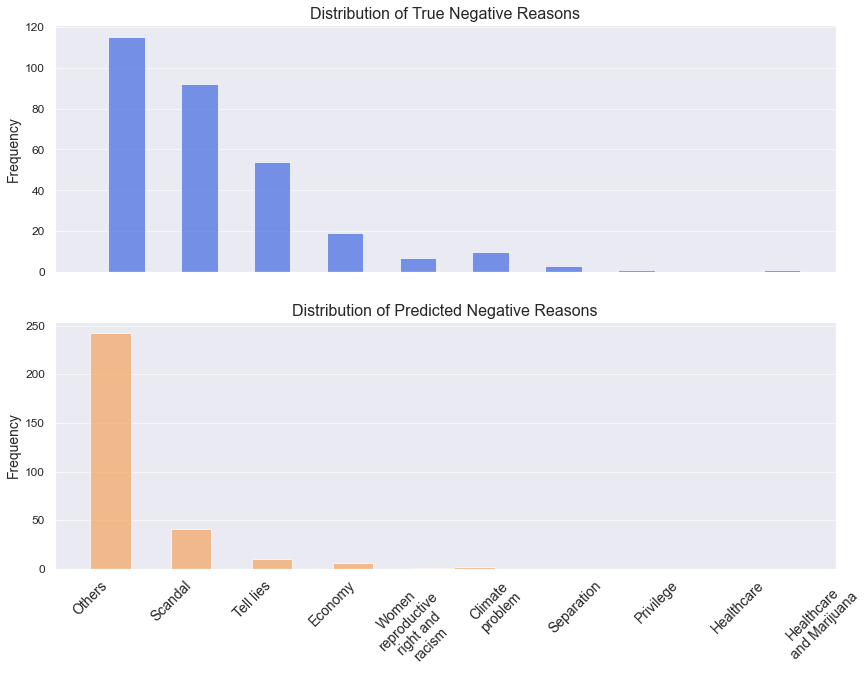

In [185]:
# Visualize predictions by Random Forest model

fig,ax = plt.subplots(2, sharex=True, figsize=(14,10))
ax[0].hist(y_test_neg, bins=10, alpha=0.7, rwidth=0.5,
                color = 'royalblue')
ax[1].hist(val_rf_neg_we, bins=10, alpha=0.7, rwidth=2,
                color = 'sandybrown')

X_label = ['Others','Scandal','Tell lies','Economy', 'Women\nreproductive\nright and\nracism','Climate\nproblem',
          'Separation','Privilege','Healthcare','Healthcare\nand Marijuana']
Y = np.arange(len(X_label))
ax[1].set_xticks(Y)
ax[1].set_xticklabels(X_label, rotation = 45, fontsize = 14)

ax[0].grid(axis='y', alpha=0.6)
ax[1].grid(axis='y', alpha=0.6)
ax[0].set_ylabel("Frequency", fontsize=14)
ax[1].set_ylabel("Frequency", fontsize=14)
plt.rc('ytick',labelsize=12)
ax[0].set_title("Distribution of True Negative Reasons", fontsize = 16)
ax[1].set_title("Distribution of Predicted Negative Reasons", fontsize = 16)
ax[0].grid(b=None, axis='x')
ax[1].grid(b=None, axis='x')
plt.show()

# 5. Results

## 5.1 The first model

As shown in section 4.1, the validation accuracy is significantly lower than the training accuracy, indicating that the model is overfitting. The count plot in section 4.1 shows that the model's performance at predicting sentiment of tweets related to the Conservative Party is fairly acceptable. However, the model noticeably assigns more "Other/Unknown" tweets with negative sentiment, whereas in the true data, more "Other/Unknown" tweets have positive sentiment. Same results are observed with "ppc" tweets, "liberal" tweets, "ndp" tweets and "gpc" tweets - the model tends to assign negative sentiment to these tweets whereas in the true data, more of these tweets have positive sentiment. 

Based on the model's perspective on the positive tweets, Liberal Party has the highest popularity in the public's eye among all 5 identified political parties. Following Liberal Party, Conservative Party and New Democratic Party have the second and third highest popularity, respectively. People's Party and Green Party have the second least and the least popularity.

Based on the results in section 4.1, it is deemed that NLP analytics based on tweets is useful to some degree but not entirely reliable. NLP analytics in section 4.1 is able to predict sentiment for some tweets and can provide a rough high-level overview of sentiment towards each political party. However, if the goal is to predict which party will win the election, the analytics above is not reliable as it tends to assign negative sentiment to the validatin tweets. To improve accuracy of the model the following recommendations could be considered:

1) Use an exhaustive/more complete list of stopwords to reduce potential noises

2) If possible, increase the amount of training data

3) Moderately increase the number of features so that the likelihood of excluding low-frequency words is reduced and at the same time the model will not result in an excessively long runtime

4) Use more sophisticated feature engineering techniques such as N-grams

## 5.2 The second model

As shown in section 4.33, the Random Forest classifier leads to a 51.32% accuracy, confirming that the model is overfitting. It can be noticed that precision, recall and f1-score for class 4,6,7 and 9 are all zero (the validation data does not contain class 8), which means the model fails to predict all of these classes due to the fact that the dataset contains a very small amount of these classes and that class 0,1,2 and 3 have proportionally higher amount. Factors and recommendations to be considered include:

1) The number of maximum features of the model may not be optimal. The value of "max_features" indicates the number of features to be considered before executing a split, which will in turn affect the complexity and performance of the model. Here in this model, "max_features" is set to its default value, which is max_features = sqrt(total number of features). Other settings include max_features = log2(total number of features) and max_features = total number of features. "log2(total number of features)" will further decrease the number of features considered at each split, whereas "total number of features" will increase the number of features considered at each split. Normally, decreasing the number of maximum features could help reduce likelihood of overfitting. Different settings for "max_features" is indeed worth exploring, and is likely to provide insights into improving the model accuracy.

2) The number of estimators of the model may be too small. The number of estimators determines the number of trees inside the model. In general, more trees will lead to better accuracy, however, will also lead to longer runtime. More values for the number of estimators should be explored here (e.g.increase the upperlimit from 1000 to maybe 2000).

3) The maximum depth of each tree may be too big. The maximum depth affects the complexity of the model. Decreasing the maximum depth helps with reducing complexity and decreasing bias. Starting with a smaller maximum depth (e.g. around 5) and then slowly increasing it may be helpful for improving the accuracy.

4) Both the training and the testing dataset are highly imbalanced, as indicated by the proportion differences between class 0 to 2 and class 3 to 9 (e.g. there are 249 class 0 samples and only 5 class 8 samples in the training dataset). Even though "class_weight" is set to "balanced", it may not have done much to help adjust the imbalance. More sophisticated methods to deal with imbalanced data may be worth trying, such as boosted decision trees.

5) If possible, gather more data to reduce the imbalance between classes and provide more features for training the model.